In [1]:
import json
import re
import sys
import os
import ast

from tqdm import tqdm
from collections import Counter
from pathlib import Path
#from pandas import json_normalize #Deprecated? Also not used

In [2]:
import sys
import re, numpy as np, pandas as pd
from pprint import pprint

from pandas.io.json import json_normalize

# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
import nltk
from gensim.utils import simple_preprocess#, lemmatize deprecetated
from gensim.models import CoherenceModel

from gensim.models.fasttext import FastText
from gensim.models import KeyedVectors
import matplotlib.pyplot as plt

from gensim.models import KeyedVectors

from nltk.corpus import stopwords
import gensim.downloader as api
import string
from sklearn.semi_supervised import LabelSpreading, LabelPropagation

/home/g/g01115/.local/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


# **`Clean and Process Data `**

In [3]:
import nltk
#nltk.download() #Dowload stopwords, only needed to update after first download

In [4]:
#Opens the data and reorganizes it by tweets instead of by events
with open('./Trec_data/labeled_by_event.json') as f:
    js = json.load(f)
df = json_normalize(data=js['events'], record_path='tweets')
df.to_json('labeled.json', orient='records', lines=True)

df

eventID eventType               postID  \
0                stormJorge2020   typhoon  1231307896362807298   
1                stormJorge2020   typhoon  1231569665043976192   
2                stormJorge2020   typhoon  1232264304067477504   
3                stormJorge2020   typhoon  1232070602778959872   
4                stormJorge2020   typhoon  1232648900105965568   
...                         ...       ...                  ...   
91510  whaleyBridgeCollapse2020     flood  1155430270457323520   
91511  whaleyBridgeCollapse2020     flood  1156993824591417346   
91512  whaleyBridgeCollapse2020     flood  1157020257388769280   
91513  whaleyBridgeCollapse2020     flood  1156926115069485056   
91514  whaleyBridgeCollapse2020     flood  1157001345649532935   

                                          postCategories postPriority  \
0                                           [Irrelevant]          Low   
1                                           [Irrelevant]          Low   
2                                           [Irrelevant]          Low   
3                                           [Irrelevant]          Low   
4                                           [Irrelevant]          Low   
...                                                  ...          ...   
91510                                       [Irrelevant]          Low   
91511  [Location, EmergingThreats, MultimediaShare, N...         High   
91512  [ThirdPartyObservation, Location, MultimediaSh...          Low   
91513  [MovePeople, ThirdPartyObservation, Location, ...     Critical   
91514                              [Hashtags, Sentiment]          Low   

                                                postText  
0      Flood Warning: River Severn at Hanley Castle a...  
1      Flood Warning: River Ouse at Naburn Lock 12:46...  
2      Our Assistant Director of Care and Support kin...  
3      @hollywills please can you help support @HopeR...  
4      Police order 'immediate evacuation' in Shropsh...  
...                                                  ...  
91510  Flood Alert: River Ecclesbourne in Derbyshire ...  
91511  Dam at Whaley Bridge in Peak District threaten...  
91512  Floods in Whaley Bridge today.\nhttps://t.co/7...  
91513  Evacuation of Whaley Bridge | Derbyshire Const...  
91514        @itvnews Praying all are safe #WhaleyBridge  

[91515 rows x 6 columns]

In [5]:
stop_words = stopwords.words('english')
stop_words.extend(["http", "https", "rt", "@", ":", "t.co", "co", "amp", "&amp;", "...", "\n", "\r"])
stop_words.extend(string.punctuation)

In [6]:
def sent_to_words(sentences):
    for sent in sentences:
        sent = str(sent)
        sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        yield(sent)

In [7]:
# Look into what shape this ./labeled.json
df = pd.read_json("labeled.json", orient='records', lines=True)
data = df.postText.values.tolist()
print(len(data))

data_words = list(sent_to_words(data))

# print(data_words[0:5]) it seems that t.co isn't in this list, so it's not being erased as a stop word
#the urls are also not being removed

91515


In [8]:
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

KeyboardInterrupt: 

In [ ]:
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner']) #Changed en to be full name en_core_web_sm #might change to trf
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]
    return texts_out

In [ ]:
print(len(data_words))

In [ ]:
data_ready = process_words(data_words)

In [13]:
#df.to_json('data_ready.json', orient='records', lines=True)

In [14]:
print(len(df.eventID), len(df.eventType), len(data_ready))
#eventID = df.eventID.values.tolist()
print(data_ready[:10])
#print(data_ready[:5])
#print(len(data_ready), len())

#I think you have to turn all empty lists into null

count = 0

for i in data_ready:
    if i == []:
        count += 1
        
print(count)

df['processed_text']=data_ready
df.to_json('processed.json', orient='records', lines=True)

91515 91515 91515
[['flood', 'warning', 'river', 'severn', 'hanley', 'castle', 'saxon', 'lode', 'february', 'klfpibzaby'], ['flood', 'warning', 'river', 'ouse', 'naburn', 'lock', 'february', 'mafelyrcnt'], ['assistant', 'director', 'care', 'support', 'kindly', 'lend', 'north', 'yorkshire', 'local', 'resilience', 'forum', 'colleague', 'kitchen', 'yesterday', 'assist', 'flooding', 'selby', 'yesterday', 'northyorkshire', 'nylrf', 'floodaware', 'chapelhaddlesey', 'templehirst', 'dlxba', 'qt'], ['help', 'support', 'follow', 'recent', 'flooding', 'pontypridd', 'charity', 'shop', 'holding', 'auction', 'donate', 'grateful', 'thank', 'dy', 'brqyesj'], ['police', 'order', 'immediate', 'evacuation', 'shropshire', 'flooding', 'krbu', 'dnbvx', 'send'], ['shrewsbury', 'flooding', 'train', 'line', 'shut', 'rise', 'river', 'level', 'nlucs'], ['flood', 'alert', 'upper', 'river', 'ouse', 'february', 'vspkayeaoh'], ['flood', 'warning', 'river', 'ouse', 'linton', 'lock', 'february', 'ludgwj', 'thz'], ['fl

In [15]:
#What does this do?
#cp -a ./PR_all_Labeled.json  gdrive/My\ Drive/Code/

In [9]:
data = pd.read_json("processed.json", orient='records',lines=True)

# Generating Similarity Scores and Matrix
### **Mean and Cosine Similarity(each event with all other event-types)**


In [10]:
import pickle
#import logging
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import MinMaxScaler, Normalizer
from sklearn.pipeline import make_pipeline
from scipy import sparse
import numpy as np
import os.path
import re
from tqdm import tqdm
import warnings
import pandas as pd

In [18]:
# remove irrelevant tweets
data = pd.read_json("processed.json", orient='records',lines=True)
print(data.columns)

data.loc[(data.eventID == 'parisAttacks2015'),'event_type']='shooting' #Do we need
def label_ir_tweets(postCategories):

    if 'Irrelevant' in postCategories:
        return 1
    else:
        return 0
data['ir'] = [label_ir_tweets(x) for x in data['postCategories']]
data=data.query("ir == 0")
# data=data.query("label ==1")

Index(['eventID', 'eventType', 'postID', 'postCategories', 'postPriority',
       'postText', 'processed_text'],
      dtype='object')


In [19]:
#This only removes all tweets except ovbservations
#Do not run but keep for reference
def label_observation_tweets(postCategories):
    if 'FirstPartyObservation' in postCategories or 'ThirdPartyObservation' in postCategories :
        return 1
    else:
        return 0
#data['obs'] = [label_observation_tweets(x) for x in data['categories']]
#data=data.query("obs == 1")
# data=data.query("label ==1")

In [21]:
data['l'] = data.apply(lambda row: len(row['processed_text']), axis=1)
data= data.query("l >1")
data.drop(columns=['l'], inplace=True)
data

/afs/cad/linux/anaconda3.8/anaconda/lib/python3.8/site-packages/pandas/core/frame.py:4110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


eventID eventType               postID  \
0                stormJorge2020   typhoon  1231307896362807296   
1                stormJorge2020   typhoon  1231569665043976192   
2                stormJorge2020   typhoon  1232264304067477504   
3                stormJorge2020   typhoon  1232070602778959872   
4                stormJorge2020   typhoon  1232648900105965568   
...                         ...       ...                  ...   
91510  whaleyBridgeCollapse2020     flood  1155430270457323520   
91511  whaleyBridgeCollapse2020     flood  1156993824591417344   
91512  whaleyBridgeCollapse2020     flood  1157020257388769280   
91513  whaleyBridgeCollapse2020     flood  1156926115069485056   
91514  whaleyBridgeCollapse2020     flood  1157001345649532928   

                                          postCategories postPriority  \
0                                           [Irrelevant]          Low   
1                                           [Irrelevant]          Low   
2                                           [Irrelevant]          Low   
3                                           [Irrelevant]          Low   
4                                           [Irrelevant]          Low   
...                                                  ...          ...   
91510                                       [Irrelevant]          Low   
91511  [Location, EmergingThreats, MultimediaShare, N...         High   
91512  [ThirdPartyObservation, Location, MultimediaSh...          Low   
91513  [MovePeople, ThirdPartyObservation, Location, ...     Critical   
91514                              [Hashtags, Sentiment]          Low   

                                                postText  \
0      Flood Warning: River Severn at Hanley Castle a...   
1      Flood Warning: River Ouse at Naburn Lock 12:46...   
2      Our Assistant Director of Care and Support kin...   
3      @hollywills please can you help support @HopeR...   
4      Police order 'immediate evacuation' in Shropsh...   
...                                                  ...   
91510  Flood Alert: River Ecclesbourne in Derbyshire ...   
91511  Dam at Whaley Bridge in Peak District threaten...   
91512  Floods in Whaley Bridge today.\nhttps://t.co/7...   
91513  Evacuation of Whaley Bridge | Derbyshire Const...   
91514        @itvnews Praying all are safe #WhaleyBridge   

                                          processed_text  
0      [flood, warning, river, severn, hanley, castle...  
1      [flood, warning, river, ouse, naburn, lock, fe...  
2      [assistant, director, care, support, kindly, l...  
3      [help, support, follow, recent, flooding, pont...  
4      [police, order, immediate, evacuation, shropsh...  
...                                                  ...  
91510  [flood, alert, river, ecclesbourne, derbyshire...  
91511  [dam, whaley, bridge, peak, district, threaten...  
91512         [flood, whaley, bridge, today, maejb, juv]  
91513  [evacuation, whaley, bridge, derbyshire, const...  
91514                         [pray, safe, whaleybridge]  

[70181 rows x 7 columns]

In [ ]:
#This would run through the ssh oopsy, do not run
#pip install -U sentence-transformers

In [22]:
# generate sentnece embedding
class SBERT:

    def __init__(self, lang="en"):
        from sentence_transformers import SentenceTransformer
        self.name = "SBERT"
        if lang == "fr":
            self.model = SentenceTransformer(
                "/home/bmazoyer/Dev/pytorch_bert/output/sts_fr_long_multilingual_bert-2019-10-01_15-07-03")
        elif lang == "en":
            self.model = SentenceTransformer(
                # "bert-large-nli-stsb-mean-tokens"
                "roberta-large-nli-stsb-mean-tokens"
            )
# roberta-large-nli-stsb-mean-tokens
    def compute_vectors(self, data):
        data["text"] = data.postText.str.slice(0, 500)
        vectors = np.array(self.model.encode(data.text.tolist()))
        return vectors

In [23]:
sbert=SBERT()

In [34]:
v=sbert.compute_vectors(data)
data['sbert_emb']=[item for item in v]

<ipython-input-22-ef607a2168ad>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["text"] = data.postText.str.slice(0, 500)


In [223]:
v

array([[ 0.67992926,  0.08545952,  0.11022005, ...,  0.4085413 ,
        -0.3779463 , -1.0206696 ],
       [ 0.7695615 , -0.23248817,  0.5518016 , ..., -0.74094415,
         0.19472353, -1.2469544 ],
       [-0.7933413 ,  0.47490934, -1.6375469 , ...,  0.41076702,
        -0.39674732,  0.5767644 ],
       ...,
       [ 0.42893374,  1.0268945 ,  0.09946147, ...,  0.15548244,
        -0.21963967, -0.30692092],
       [-0.77845883, -0.1347617 , -0.03813635, ..., -0.04873311,
         1.268398  , -0.43941018],
       [ 0.28480676, -0.41410762, -0.81820065, ...,  0.3380657 ,
         0.84363127,  0.38619763]], dtype=float32)

In [35]:
from numpy import dot
from numpy.linalg import norm

In [36]:
#Can't handle the list of postType
def generate_similarity_matrix (frame, grouping, group_types):
    #generate similarity scores dataframe
    group_ranks=pd.DataFrame()
    for heldout_event in group_types:

        training = frame[frame[grouping] != heldout_event]
        test = frame[frame[grouping] == heldout_event]

        ref=np.mean(test["sbert_emb"], axis=0)

        grpups=training.groupby(grouping) #Might need to be changed 
        ranks={}
        ranks["reference-group"]=heldout_event
        for name, group in grpups:
           val=np.mean(group["sbert_emb"], axis=0)
           cos_sim = dot(ref, val)/(norm(ref)*norm(val))
           ranks[name]=cos_sim

        # event_ranks[heldout_event]=ranks
        #print(ranks)
        group_ranks = group_ranks.append(ranks, ignore_index=True)
    group_ranks.set_index("reference-group",inplace=True)
    #group_ranks=frame.groupby(grouping) #Does the label==1 need to change?
    return group_ranks

In [6]:
import seaborn as sns

In [38]:
#is this even required? and is this based off the 4 different sources?
events=[ 
'2014_Philippines_Typhoon_Hagupi',
 '2015_Cyclone_Pam',
 'albertaFloods2013',
 'albertaWildfires2019',
 'australiaBushfire2013',
 'cycloneKenneth2019',
 'fireYMM2016',
 'hurricaneFlorence2018',
 'keralaFloods2019',
 'manilaFloods2013',
 'philipinnesFloods2012',
 'queenslandFloods2013',
 'southAfricaFloods2019',
 'typhoonHagupit2014',
 'typhoonYolanda2013'
]
event_types=['typhoon', 'storm', 'wildfire', 'covid', 'flood',
       'shooting', 'earthquake', 'explosion', 'hostage', 'fire',
       'tornado']
event_types

['typhoon',
 'storm',
 'wildfire',
 'covid',
 'flood',
 'shooting',
 'earthquake',
 'explosion',
 'hostage',
 'fire',
 'tornado']

In [41]:
event_ranks = generate_similarity_matrix(data, 'eventType', event_types)
event_ranks = event_ranks.replace(np.nan, 1)
event_ranks.to_csv("event_ranks.csv")
event_ranks
#cp -a ./event_ranks_roberta.csv gdrive/My\ Drive/Code/

covid  earthquake  explosion      fire     flood  \
reference-group                                                        
typhoon          0.733668    0.778466   0.656204  0.668902  0.896125   
storm            0.651968    0.668615   0.637722  0.577227  0.759442   
wildfire         0.690234    0.600284   0.651082  0.695409  0.747426   
covid            1.000000    0.635499   0.627631  0.595955  0.704632   
flood            0.704632    0.681584   0.619592  0.678830  1.000000   
shooting         0.639130    0.477076   0.630731  0.499933  0.558234   
earthquake       0.635499    1.000000   0.700250  0.596944  0.681584   
explosion        0.627631    0.700250   1.000000  0.704938  0.619592   
hostage          0.591867    0.445367   0.476008  0.490907  0.504696   
fire             0.595955    0.596944   0.704938  1.000000  0.678830   
tornado          0.652033    0.662821   0.758384  0.595637  0.626563   

                  hostage  shooting     storm   tornado  wildfire   typhoon  
reference-group                                                              
typhoon          0.515935  0.514979  0.873572  0.699830  0.762640  1.000000  
storm            0.457391  0.531805  1.000000  0.771875  0.724501  0.873572  
wildfire         0.460422  0.525417  0.724501  0.721884  1.000000  0.762640  
covid            0.591867  0.639130  0.651968  0.652033  0.690234  0.733668  
flood            0.504696  0.558234  0.759442  0.626563  0.747426  0.896125  
shooting         0.667633  1.000000  0.531805  0.559754  0.525417  0.514979  
earthquake       0.445367  0.477076  0.668615  0.662821  0.600284  0.778466  
explosion        0.476008  0.630731  0.637722  0.758384  0.651082  0.656204  
hostage          1.000000  0.667633  0.457391  0.475423  0.460422  0.515935  
fire             0.490907  0.499933  0.577227  0.595637  0.695409  0.668902  
tornado          0.475423  0.559754  0.771875  1.000000  0.721884  0.699830

In [147]:
critical_types=['Low', 'Medium', 'High', 'Critical']
print((critical_types))
critical_ranks = generate_similarity_matrix(data, 'postPriority', critical_types) #check what this variable is called in the dataframe
critical_ranks = critical_ranks.replace(np.nan, 1)
critical_ranks.to_csv("critical_ranks.csv")
critical_ranks

['Low', 'Medium', 'High', 'Critical']


Critical      High    Medium       Low
reference-group                                        
Low              0.907178  0.950713  0.973240  1.000000
Medium           0.911126  0.971996  1.000000  0.973240
High             0.938004  1.000000  0.971996  0.950713
Critical         1.000000  0.938004  0.911126  0.907178

In [159]:
for i in data['postCategories']:
    print(len(i))

1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


In [153]:
info_types=df['postCategories'].explode().unique() #double check that this is string based
info_types = info_types.tolist()
info_types = ['Irrelevant', 'Location', 'MultimediaShare', 'ContextualInformation', 'Weather', 'Discussion', 'Hashtags', 'News', 'Official', 'EmergingThreats', 'FirstPartyObservation', 'Factoid', 'ThirdPartyObservation', 'MovePeople', 'Sentiment', 'Advice', 'GoodsServices', 'Donations', 'ServiceAvailable', 'SearchAndRescue', 'NewSubEvent', 'Volunteer', 'CleanUp', 'InformationWanted', 'OriginalEvent']

In [224]:
cat = []
for i in data['postCategories']:
    if len(i) == 1:
        listToStr = ' '.join(map(str, i))
        cat.append(listToStr)
    else:
        i = tuple(i)
        #listToStr = ' '.join(map(str, i))
        cat.append(i)
        
print(cat)

['Irrelevant', 'Irrelevant', 'Irrelevant', 'Irrelevant', 'Irrelevant', 'Irrelevant', 'Irrelevant', 'Irrelevant', 'Irrelevant', 'Irrelevant', 'Irrelevant', 'Irrelevant', 'Irrelevant', 'Irrelevant', 'Irrelevant', 'Irrelevant', 'Irrelevant', 'Irrelevant', 'Irrelevant', 'Irrelevant', 'Irrelevant', 'Irrelevant', 'Irrelevant', 'Irrelevant', 'Irrelevant', 'Irrelevant', 'Irrelevant', 'Irrelevant', 'Irrelevant', 'Irrelevant', 'Irrelevant', 'Irrelevant', 'Irrelevant', 'Irrelevant', 'Irrelevant', 'Irrelevant', 'Irrelevant', 'Irrelevant', 'Irrelevant', 'Irrelevant', 'Irrelevant', 'Irrelevant', 'Irrelevant', 'Irrelevant', 'Irrelevant', 'Irrelevant', 'Irrelevant', 'Irrelevant', 'Irrelevant', 'Irrelevant', 'Irrelevant', 'Irrelevant', 'Irrelevant', 'Irrelevant', 'Irrelevant', 'Irrelevant', 'Irrelevant', 'Irrelevant', 'Irrelevant', 'Irrelevant', 'Irrelevant', 'Irrelevant', 'Irrelevant', 'Irrelevant', 'Irrelevant', 'Irrelevant', 'Irrelevant', 'Irrelevant', 'Irrelevant', 'Irrelevant', 'Irrelevant', 'Irre

In [190]:
cat = map(lambda s: s.strip(), cat)

converted_list = []


for element in cat:
    print(type(element))
    converted_list.append(element.strip())

In [230]:
cut = []
for i in data['postCategories']:
    if len(i) == 1:
        listToStr = ' '.join(map(str, i))
        cut.append(listToStr)
    else:
        i = i[0]
        listToStr = ''.join(map(str, i))
        cut.append(listToStr)

In [225]:
data['tupled']=[item for item in cat]

In [231]:
data['first_info']=[item for item in cut]

In [232]:
data.head()

eventID eventType               postID postCategories postPriority  \
0  stormJorge2020   typhoon  1231307896362807296   [Irrelevant]          Low   
1  stormJorge2020   typhoon  1231569665043976192   [Irrelevant]          Low   
2  stormJorge2020   typhoon  1232264304067477504   [Irrelevant]          Low   
3  stormJorge2020   typhoon  1232070602778959872   [Irrelevant]          Low   
4  stormJorge2020   typhoon  1232648900105965568   [Irrelevant]          Low   

                                            postText  \
0  Flood Warning: River Severn at Hanley Castle a...   
1  Flood Warning: River Ouse at Naburn Lock 12:46...   
2  Our Assistant Director of Care and Support kin...   
3  @hollywills please can you help support @HopeR...   
4  Police order 'immediate evacuation' in Shropsh...   

                                      processed_text  \
0  [flood, warning, river, severn, hanley, castle...   
1  [flood, warning, river, ouse, naburn, lock, fe...   
2  [assistant, director, care, support, kindly, l...   
3  [help, support, follow, recent, flooding, pont...   
4  [police, order, immediate, evacuation, shropsh...   

                                                text  \
0  Flood Warning: River Severn at Hanley Castle a...   
1  Flood Warning: River Ouse at Naburn Lock 12:46...   
2  Our Assistant Director of Care and Support kin...   
3  @hollywills please can you help support @HopeR...   
4  Police order 'immediate evacuation' in Shropsh...   

                                           sbert_emb      tupled  first_info  
0  [0.67992926, 0.08545952, 0.11022005, 0.6025064...  Irrelevant  Irrelevant  
1  [0.7695615, -0.23248817, 0.5518016, 1.4116685,...  Irrelevant  Irrelevant  
2  [-0.7933413, 0.47490934, -1.6375469, 0.3820564...  Irrelevant  Irrelevant  
3  [-0.21973538, 1.6360041, -0.66423476, 0.031241...  Irrelevant  Irrelevant  
4  [-0.3594531, -0.9384976, 0.7266449, -0.0124636...  Irrelevant  Irrelevant

In [226]:
#info_ranks = generate_similarity_matrix(data, 'postCategories', info_types) #check what this variable is called in the dataframe
info_ranks = generate_similarity_matrix(data, 'tupled', info_types)
info_ranks.to_csv("info_ranks.csv")
info_ranks

(Advice, Discussion)  \
reference-group                                                            
Irrelevant                                                      0.687762   
Location                                                        0.416636   
MultimediaShare                                                 0.415375   
ContextualInformation                                           0.664127   
Weather                                                         0.334725   
Discussion                                                      0.727361   
Hashtags                                                         0.64892   
News                                                            0.657199   
Official                                                        0.588192   
EmergingThreats                                                 0.475843   
FirstPartyObservation                                           0.461411   
Factoid                                                         0.577357   
ThirdPartyObservation                                           0.705092   
MovePeople                                                      0.329129   
Sentiment                                                       0.698922   
Advice                                                          0.818527   
GoodsServices                                                   0.462794   
Donations                                                       0.458687   
ServiceAvailable                                                 0.50839   
SearchAndRescue                                                 0.193042   
NewSubEvent            [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
Volunteer                                                        0.49762   
CleanUp                [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
InformationWanted                                               0.533718   
OriginalEvent                                                   0.340506   

                                                    (Advice, Irrelevant)  \
reference-group                                                            
Irrelevant                                                      0.392284   
Location                                                        0.483184   
MultimediaShare                                                 0.370895   
ContextualInformation                                           0.294938   
Weather                                                         0.218992   
Discussion                                                      0.367061   
Hashtags                                                        0.470286   
News                                                            0.275649   
Official                                                        0.266869   
EmergingThreats                                                  0.27003   
FirstPartyObservation                                           0.297831   
Factoid                                                         0.290138   
ThirdPartyObservation                                           0.228376   
MovePeople                                                      0.277353   
Sentiment                                                       0.578906   
Advice                                                          0.429735   
GoodsServices                                                  0.0905064   
Donations                                                        0.10171   
ServiceAvailable                                               0.0708145   
SearchAndRescue                                                0.0664744   
NewSubEvent            [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
Volunteer                                                       0.108315   
CleanUp                [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
InformationWanted                                               0.285237   
OriginalEvent          

In [2]:
#info_ranks = generate_similarity_matrix(data, 'postCategories', info_types) #check what this variable is called in the dataframe
info_ranks = generate_similarity_matrix(data, 'first_info', info_types)
info_ranks.to_csv("info_ranks_first.csv")
info_ranks

NameError: name 'generate_similarity_matrix' is not defined

In [1]:
#info_ranks = generate_similarity_matrix(data, 'postCategories', info_types) #check what this variable is called in the dataframe
info_ranks = info_ranks.replace(np.nan, 1)
info_ranks.to_csv("info_ranks_first.csv")
info_ranks

NameError: name 'info_ranks' is not defined

In [15]:
import pandas as pd
info_ranks = pd.read_csv("info_ranks_first.csv", index_col = 0)
info_ranks

OriginalEvent  InformationWanted   CleanUp  Volunteer  \
reference-group                                                                
Irrelevant                  0.655521           0.881362  0.764980   0.787966   
Location                    0.639220           0.858354  0.809209   0.756873   
MultimediaShare             0.660452           0.879990  0.757189   0.768631   
ContextualInformation       0.573432           0.813515  0.703964   0.802333   
Weather                     0.468867           0.720955  0.793975   0.652312   
Discussion                  0.608449           0.809130  0.674251   0.742755   
Hashtags                    0.738661           0.831541  0.691246   0.711155   
News                        0.524064           0.766473  0.651079   0.750564   
Official                    0.515745           0.816230  0.711181   0.775481   
EmergingThreats             0.675455           0.837279  0.767674   0.748366   
FirstPartyObservation       0.594307           0.866606  0.822420   0.780222   
Factoid                     0.683765           0.823833  0.704821   0.698166   
ThirdPartyObservation       0.688965           0.853201  0.714005   0.696011   
MovePeople                  0.457319           0.700503  0.661669   0.604859   
Sentiment                   0.844976           0.766520  0.633902   0.658303   
Advice                      0.598603           0.737019  0.605492   0.682099   
GoodsServices               0.442806           0.763184  0.777830   0.919984   
Donations                   0.368045           0.662703  0.669024   0.916798   
ServiceAvailable            0.399654           0.778860  0.643092   0.877469   
SearchAndRescue             0.545318           0.868504  0.743474   0.754378   
NewSubEvent                 0.512048           0.787660  0.674697   0.622701   
Volunteer                   0.405857           0.745518  0.704919   1.000000   
CleanUp                     0.418891           0.669017  1.000000   0.704919   
InformationWanted           0.626414           1.000000  0.669017   0.745518   
OriginalEvent               1.000000           0.626414  0.418891   0.405857   

                       NewSubEvent  SearchAndRescue  ServiceAvailable  \
reference-group                                                         
Irrelevant                0.862472         0.837643          0.844509   
Location                  0.875769         0.850328          0.775782   
MultimediaShare           0.873947         0.849620          0.813332   
ContextualInformation     0.761260         0.741343          0.873898   
Weather                   0.771898         0.765541          0.648423   
Discussion                0.705535         0.725705          0.795402   
Hashtags                  0.662735         0.803408          0.671842   
News                      0.715971         0.701830          0.854388   
Official                  0.745388         0.742925          0.868548   
EmergingThreats           0.817000         0.843038          0.754325   
FirstPartyObservation     0.833046         0.862362          0.806847   
Factoid                   0.856070         0.793109          0.742227   
ThirdPartyObservation     0.845829         0.830105          0.762135   
MovePeople                0.718404         0.712438          0.583796   
Sentiment                 0.608803         0.706946          0.636238   
Advice                    0.630304         0.667848          0.753356   
GoodsServices             0.655547         0.795196          0.814029   
Donations                 0.532866         0.682200          0.799370   
ServiceAvailable          0.694995         0.700651          1.000000   
SearchAndRescue           0.775154         1.000000          0.700651   
NewSubEvent               1.000000         0.775154          0.694995   
Volunteer                 0.622701         0.754378          0.877469   
CleanUp                   0.674697         0.743474          0.643092   
InformationWanted         0.787660   

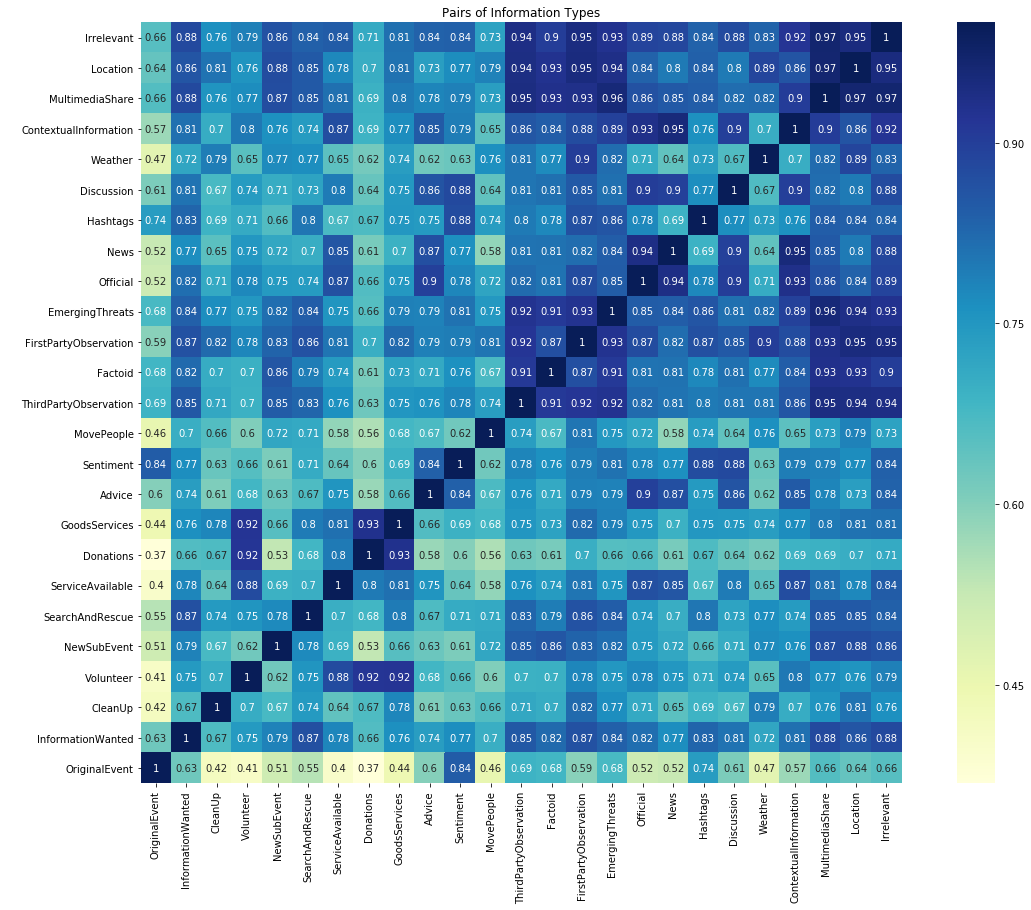

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,14))

ax = plt.axes()

ax.set_title('Pairs of Information Types')

sns.heatmap(info_ranks, ax=ax,cmap="YlGnBu", annot=True, square=True)
plt.ylabel(' ')
#sns.heatmap(dt_tweet_cnt, ax=ax2)

b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.show() # ta-da!

plt.show()

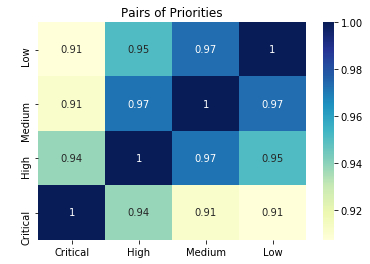

'3.1.1'

In [84]:
import matplotlib.pyplot as plt
ax = plt.axes()

ax.set_title('Pairs of Priorities')
sns.heatmap(critical_ranks, ax=ax,cmap="YlGnBu", annot=True)
plt.ylabel(' ')
#sns.heatmap(dt_tweet_cnt, ax=ax2)

b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.show() # ta-da!

plt.show()

import matplotlib
matplotlib.__version__

In [120]:
event_ranks = pd.read_csv("event_ranks.csv", index_col = 0)
#type(event_ranks)

In [123]:
event_ranks_final = pd.read_csv("event_ranks_final.csv", index_col = 0)
event_ranks_final

tornado      fire   hostage  explosion  earthquake  \
reference-group                                                        
typhoon          0.699830  0.668902  0.515935   0.656204    0.778466   
storm            0.771875  0.577227  0.457391   0.637722    0.668615   
wildfire         0.721884  0.695409  0.460422   0.651082    0.600284   
covid            0.652033  0.595955  0.591867   0.627631    0.635499   
flood            0.626563  0.678830  0.504696   0.619592    0.681584   
shooting         0.559754  0.499933  0.667633   0.630731    0.477076   
earthquake       0.662821  0.596944  0.445367   0.700250    1.000000   
explosion        0.758384  0.704938  0.476008   1.000000    0.700250   
hostage          0.475423  0.490907  1.000000   0.476008    0.445367   
fire             0.595637  1.000000  0.490907   0.704938    0.596944   
tornado          1.000000  0.595637  0.475423   0.758384    0.662821   

                 shooting     flood     covid  wildfire     storm   typhoon  
reference-group                                                              
typhoon          0.514979  0.896125  0.733668  0.762640  0.873572  1.000000  
storm            0.531805  0.759442  0.651968  0.724501  1.000000  0.873572  
wildfire         0.525417  0.747426  0.690234  1.000000  0.724501  0.762640  
covid            0.639130  0.704632  1.000000  0.690234  0.651968  0.733668  
flood            0.558234  1.000000  0.704632  0.747426  0.759442  0.896125  
shooting         1.000000  0.558234  0.639130  0.525417  0.531805  0.514979  
earthquake       0.477076  0.681584  0.635499  0.600284  0.668615  0.778466  
explosion        0.630731  0.619592  0.627631  0.651082  0.637722  0.656204  
hostage          0.667633  0.504696  0.591867  0.460422  0.457391  0.515935  
fire             0.499933  0.678830  0.595955  0.695409  0.577227  0.668902  
tornado          0.559754  0.626563  0.652033  0.721884  0.771875  0.699830

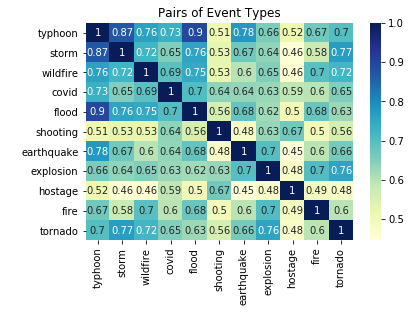

In [124]:
# Visualize similarity matrix for event type using heatmap

import matplotlib.pyplot as plt
ax = plt.axes()

ax.set_title('Pairs of Event Types')
sns.heatmap(event_ranks, ax=ax,cmap="YlGnBu", annot=True)
plt.ylabel(' ')
#sns.heatmap(dt_tweet_cnt, ax=ax2)

b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.show() # ta-da!

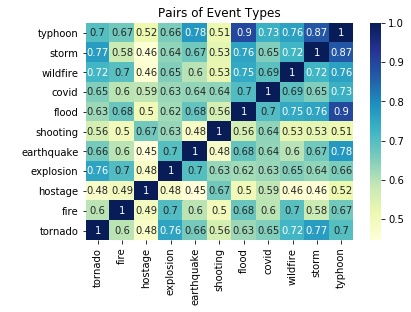

In [126]:
# Visualize similarity matrix for event type using heatmap

import matplotlib.pyplot as plt
ax = plt.axes()

ax.set_title('Pairs of Event Types')
sns.heatmap(event_ranks_final, ax=ax,cmap="YlGnBu", annot=True)
plt.ylabel(' ')
#sns.heatmap(dt_tweet_cnt, ax=ax2)

b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.show() # ta-da!